In [ ]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Read and Process E-Commerce data with NVTabular

In this notebook, we are going to use a subset of the publicly available [eCommerce dataset](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). The e-commerce behavior data contains 7 months data (from October 2019 to April 2020) from a large multi-category online store. Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.
Data collected by Open CDP project and the source of the dataset is [REES46 Marketing Platform](https://rees46.com/).

We use only `2019-Oct.csv` file for training our models, so you can visit this site and download the csv file: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store.

- Import the required libraries

In [2]:
import os
import numpy as np 
import pandas as pd
import gc
import shutil
import glob

import cudf
import cupy
import nvtabular as nvt
from nvtabular import ColumnSelector

## Define Input/Output Directories

A this point we expect that you have already downloaded the `2019-Oct.csv` dataset and stored it in the `INPUT_DATA_DIR` as defined below.

In [3]:
# define some information about where to get our data
BASE_DIR = os.environ.get("BASE_DIR", "/workspace/")
INPUT_DATA_DIR = os.environ.get("INPUT_DATA_DIR", BASE_DIR + "ecommerce/")
OUTPUT_DATA_DIR = os.environ.get("OUTPUT_DATA_DIR", BASE_DIR + "ecommerce/output_tmp/")

INPUT_PATH= os.path.join(INPUT_DATA_DIR, 'input/')
!mkdir -p $INPUT_PATH

## Configurations

We will only use 2019-Oct dataset.

In [4]:
selected_months = ["2019-Oct.csv"]

In [5]:
files_paths = [os.path.join(INPUT_DATA_DIR, file) for file in selected_months]
files_paths

['/workspace/ecommerce/2019-Oct.csv']

## Read Data via cuDF from CSV

In [6]:
%%time
raw_df = cudf.read_csv(files_paths[0]) 
raw_df.head()

CPU times: user 2.81 s, sys: 1.27 s, total: 4.08 s
Wall time: 4.32 s


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,<NA>,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,<NA>,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [7]:
raw_df.shape

(42448764, 9)

## PREPROCESSING

### Convert timestamp from datetime

In [8]:
raw_df['event_time_dt'] = raw_df['event_time'].astype('datetime64[s]')
raw_df['event_time_ts']= raw_df['event_time_dt'].astype('int')

In [9]:
# check out the columns with nulls
raw_df.isnull().any()

event_time       False
event_type       False
product_id       False
category_id      False
category_code     True
brand             True
price            False
user_id          False
user_session      True
event_time_dt    False
event_time_ts    False
dtype: bool

In [10]:
# Remove rows where `user_session` is null.
raw_df = raw_df[raw_df['user_session'].isnull()==False]
len(raw_df)

42448762

### Categorify `user_session` column

In [11]:
cols = list(raw_df.columns)
cols.remove('user_session')
cols

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'event_time_dt',
 'event_time_ts']

In [12]:
# load data 
df_event = nvt.Dataset(raw_df) 

# categorify user_session 
cat_feats = ['user_session'] >> nvt.ops.Categorify()

workflow = nvt.Workflow(cols + cat_feats)
workflow.fit(df_event)
df = workflow.transform(df_event).to_ddf().compute()

In [13]:
df = df.drop(['event_time'],  axis=1)

In [15]:
df.head()

,user_session,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_dt,event_time_ts
0,5126085,view,44600062,2103807459595387724,<NA>,shiseido,35.79,541312140,2019-10-01 00:00:00,1569888000
1,7854470,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,2019-10-01 00:00:00,1569888000
2,730655,view,17200506,2053013559792632471,furniture.living_room.sofa,<NA>,543.10,519107250,2019-10-01 00:00:01,1569888001
3,1637332,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,2019-10-01 00:00:01,1569888001
4,4202155,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,2019-10-01 00:00:04,1569888004


In [16]:
df.shape

(42448762, 10)

In [17]:
raw_df = None
del(raw_df)

In [18]:
gc.collect()

0

### Removing repeated (user, item) interactions

In [19]:
%%time

# Keeps repeated interactions on the same items, removing only consecutive interactions, 
# because it might be due to browser tab refreshes or different interaction types (e.g. click, add-to-card, purchase)

df = df.sort_values(['user_session', 'event_time_ts']).reset_index(drop=True)

print("Count with in-session repeated interactions: {}".format(len(df)))
# Sorts the dataframe by session and timestamp, to remove consecutive repetitions
df['product_id_past'] = df['product_id'].shift(1).fillna(0)
df['session_id_past'] = df['user_session'].shift(1).fillna(0)
#Keeping only no consecutive repeated in session interactions
df = df[~((df['user_session'] == df['session_id_past']) & \
             (df['product_id'] == df['product_id_past']))]
print("Count after removed in-session repeated interactions: {}".format(len(df)))
del(df['product_id_past'])
del(df['session_id_past'])

gc.collect()

Count with in-session repeated interactions: 42448762
Count after removed in-session repeated interactions: 30733301
CPU times: user 747 ms, sys: 142 ms, total: 890 ms
Wall time: 986 ms


0

### Include the item first time seen feature (for recency calculation)¶

In [20]:
item_first_interaction_df = df.groupby('product_id').agg({'event_time_ts': 'min'}).reset_index().rename(columns={'event_time_ts': 'prod_first_event_time_ts'})
item_first_interaction_df.head()
gc.collect()

0

In [21]:
df = df.merge(item_first_interaction_df, on=['product_id'], how='left').reset_index(drop=True)

In [22]:
df.head()

,user_session,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_dt,event_time_ts,prod_first_event_time_ts
0,94,view,26202560,2053013563693335403,<NA>,<NA>,388.49,512892706,2019-10-15 17:21:59,1571160119,1569925682
1,94,view,26203994,2053013563693335403,<NA>,<NA>,157.79,512892706,2019-10-15 17:22:17,1571160137,1569941460
2,94,view,26204036,2053013563693335403,<NA>,sokolov,471.70,512892706,2019-10-15 17:22:29,1571160149,1569897265
3,94,view,26203994,2053013563693335403,<NA>,<NA>,157.79,512892706,2019-10-15 17:22:58,1571160178,1569941460
4,94,view,26203727,2053013563693335403,<NA>,lucente,317.38,512892706,2019-10-15 17:23:19,1571160199,1569901056


- Check out if there is any column with missing (null) values.

In [23]:
df.isnull().any()

user_session                False
event_type                  False
product_id                  False
category_id                 False
category_code                True
brand                        True
price                       False
user_id                     False
event_time_dt               False
event_time_ts               False
prod_first_event_time_ts    False
dtype: bool

In [24]:
del(item_first_interaction_df)
item_first_interaction_df=None
gc.collect()

0

You need to run this cell only once and then comment out if you would like to rerun the same pipeline. We'll use this saved parquet file below in the NVTabular workflow.

In [25]:
# save df as parquet files on disk
df.to_parquet(os.path.join(INPUT_PATH, 'input.parquet'))

## FEATURE ENGINEERING with NVTabular

### Categorical features encoding


We see that `'category_code', 'brand'` columns have null values, and in the following cell we are going to fill these nulls with via categorify op, and then all categorical columns will be encoded to continuous integers. Note that we also add `1` after we categorify the categorical columns, the reason for that we want the encoded null values to start from `1` instead of `0` because we reserve `0` for padding the seqeunce features.

In [26]:
cols= ['event_time_dt', 'event_time_ts', 'user_session']

In [27]:
# categorify categorical features 
cat_feats = ['category_code', 'brand', 'user_id', 'product_id', 'category_id', 'event_type'] >> nvt.ops.Categorify() >> nvt.ops.LambdaOp(lambda col: col +1)

### Extract Temporal Features

In [28]:
# create time features
sessionTime = ['event_time_dt']

sessionTime_hour = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.hour) >> 
    nvt.ops.Rename(name = 'et_hour')
)
sessionTime_weekday = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.weekday) >> 
    nvt.ops.Rename(name ='et_dayofweek')
)
sessionTime_day = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.day) >> 
    nvt.ops.Rename(name ="et_dayofmonth")
)
sessionTime_month = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.month) >> 
    nvt.ops.Rename(name ="et_month")
)

In [29]:
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

In [30]:
hour_sin = sessionTime_hour >> (lambda col: get_cycled_feature_value_sin(col, 24)) >> nvt.ops.Rename(name='et_hour_sin')
hour_cos = sessionTime_hour >> (lambda col: get_cycled_feature_value_cos(col, 24)) >> nvt.ops.Rename(name ='et_hour_cos')
weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(name = 'et_dayofweek_sin')
weekday_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col+1, 7)) >> nvt.ops.Rename(name = 'et_dayofweek_cos')

dayofmonth_sin = sessionTime_hour >> (lambda col: get_cycled_feature_value_sin(col, 31)) >> nvt.ops.Rename(name ='et_dayofmonth_sin')
dayofmonth_cos = sessionTime_hour >> (lambda col: get_cycled_feature_value_cos(col, 31)) >> nvt.ops.Rename(name='et_dayofmonth_cos')
month_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col, 12)) >> nvt.ops.Rename(name='et_month_sin')
month_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col, 12)) >> nvt.ops.Rename(name = 'et_month_cos')

In [31]:
cycled_features = hour_sin + hour_cos + weekday_sin + weekday_cos + dayofmonth_sin + dayofmonth_cos + month_sin + month_cos

- Calculate item recency 

In [32]:
# create custom op
from nvtabular.ops import Operator

class ItemRecency(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            item_first_timestamp = gdf['prod_first_event_time_ts']
            delta_days = (col - item_first_timestamp) / (60*60*24)
            gdf[column + "_age_days"] = delta_days * (delta_days >=0)
        return gdf
            
    def output_column_names(self, columns):
        return ColumnSelector([column + "_age_days" for column in columns])
            
    def dependencies(self):
        return ["prod_first_event_time_ts"]

In [33]:
recency_features = ["event_time_ts"] >> ItemRecency() >>  nvt.ops.Rename(name='product_recency_days')
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name='product_recency_days_log_norm')

In [34]:
time_features = (
    sessionTime_hour +
    sessionTime_day + 
    sessionTime_month + 
    sessionTime_weekday +
    cycled_features +
    recency_features_norm
)

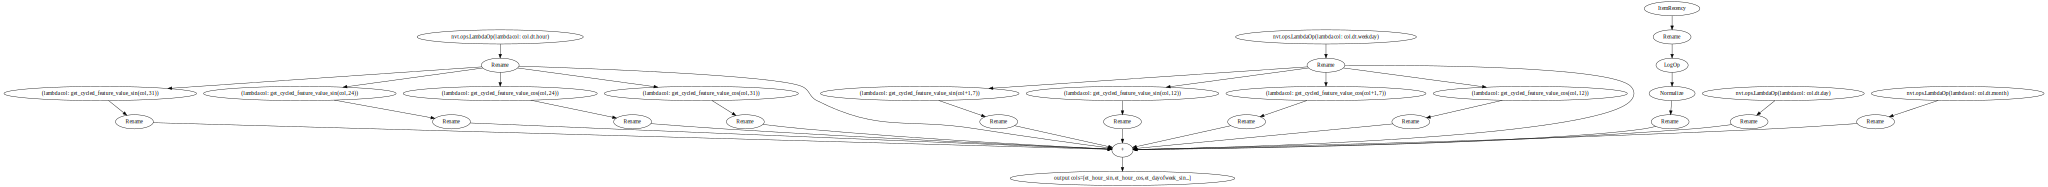

In [35]:
time_features.graph

### Computing elapsed time since last interaction (on non-repeated items)

In [36]:
# compute the delta in timestamp for each users session
diff_features = (["event_time_ts"] >> nvt.ops.DifferenceLag(partition_cols=["user_session"]) >> (lambda col: col.astype("float32"))
                                   >> nvt.ops.FillMissing(fill_val=0)
                                   >> nvt.ops.Rename(name="delta_event_secs")
                )
diff_features_log_norm = diff_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name='delta_event_secs_log_norm')

### Normalize Continuous Features¶

In [37]:
# Smoothing price long-tailed distribution
price_log = ['price'] >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name='price_log_norm')

In [38]:
# Relative Price to the average price for the category_id
def relative_price_to_avg_categ(col, gdf):
    epsilon = 1e-5
    col = ((gdf['price'] - col) / (col + epsilon)) * (col > 0).astype(int)
    return col
    
avg_category_id_pr = ['category_id'] >> nvt.ops.JoinGroupby(cont_cols =['price'], stats=["mean"]) >> nvt.ops.Rename(name='avg_category_id_price')
relative_price_to_avg_category = avg_category_id_pr >> nvt.ops.LambdaOp(relative_price_to_avg_categ, dependency=['price']) >> nvt.ops.Rename(name="relative_price_to_avg_categ_id")

### Grouping interactions into sessions¶

In [39]:
groupby_feats = cols + cat_feats + time_features + avg_category_id_pr + price_log + relative_price_to_avg_category + diff_features_log_norm

#### Aggregate by session id (create sequence as type of array)

In [40]:
# Define Groupby Workflow
groupby_features = groupby_feats  >> nvt.ops.Groupby(
    groupby_cols=["user_session"], 
    sort_cols=["event_time_ts"],
    aggs={
        'user_id': ['first'],
        'product_id': ["list", "count"],
        'category_code': ["list"],  
        'event_type': ["list"], 
        'brand': ["list"], 
        'category_id': ["list"], 
        'event_time_ts': ["list", "first"],
        'event_time_dt': ["first"],
        'product_recency_days_log_norm': ["list"],
        'et_hour_sin': ["list"],
        'et_hour_cos': ["list"],
        'et_dayofweek_sin': ["list"],
        'et_dayofweek_cos': ["list"],
        'et_dayofmonth_sin': ["list"],
        'et_dayofmonth_cos': ["list"],
        'et_month_sin': ["list"],
        'et_month_cos': ["list"], 
        'avg_category_id_price': ["list"], 
        'relative_price_to_avg_categ_id': ["list"], 
        'price_log_norm': ["list"], 
        'delta_event_secs_log_norm': ["list"], 
        },
    name_sep="-")

In [41]:
groupby_features_nonlist = [x for x in groupby_features.output_columns.names if '-list' not in x]
groupby_features_nonlist

['product_id-count',
 'event_time_dt-first',
 'event_time_ts-first',
 'user_id-first',
 'user_session']

In [42]:
SESSIONS_MAX_LENGTH = 20 
MINIMUM_SESSION_LENGTH = 2

In [43]:
groupby_features_trim = ((groupby_features - groupby_features_nonlist)) >> nvt.ops.ListSlice(0,SESSIONS_MAX_LENGTH) >> nvt.ops.Rename(postfix = '_seq')

/nvtabular/nvtabular/workflow/node.py:45: FutureWarning: The `["a", "b", "c"] >> ops.Operator` syntax for creating a `ColumnGroup` has been deprecated in NVTabular 21.09 and will be removed in a future version.
  warnings.warn(


In [44]:
day_index = (groupby_features['event_time_dt-first'] >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(name = "day_index")
)

In [45]:
day_padded = day_index >> (lambda col: col.astype(str).str.pad(4,fillchar='0')) >> nvt.ops.Rename(name="day_padded")

In [46]:
selected_features = groupby_features[groupby_features_nonlist] + groupby_features_trim + day_padded

- Select sessions with session size is equal and longer than the MINIMUM_SESSION_LENGTH.

In [47]:
filtered_sessions = (selected_features-['event_time_dt-first']) >> nvt.ops.Filter(f=lambda df: df["product_id-count"] >= MINIMUM_SESSION_LENGTH)

In [48]:
# define the path of the saved parquet files 
input_paths = glob.glob(os.path.join(INPUT_PATH, '*.parquet'))
input_paths

['/workspace/ecommerce/input/input.parquet']

In [49]:
dataset = nvt.Dataset(input_paths, part_size="256MB")
workflow = nvt.Workflow(filtered_sessions)
workflow.fit(dataset)

/root/.local/lib/python3.8/site-packages/numba-0.54.0rc2-py3.8-linux-x86_64.egg/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/root/.local/lib/python3.8/site-packages/numba-0.54.0rc2-py3.8-linux-x86_64.egg/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/root/.local/lib/python3.8/site-packages/numba-0.54.0rc2-py3.8-linux-x86_64.egg/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [50]:
sessions_gdf = workflow.transform(dataset).to_ddf()

In [51]:
sessions_gdf.head(2)

,product_id-count,event_time_ts-first,user_id-first,user_session,et_hour_sin-list_seq,brand-list_seq,event_time_ts-list_seq,category_code-list_seq,et_month_cos-list_seq,et_dayofmonth_cos-list_seq,...,et_dayofweek_cos-list_seq,et_month_sin-list_seq,category_id-list_seq,product_recency_days_log_norm-list_seq,price_log_norm-list_seq,delta_event_secs_log_norm-list_seq,avg_category_id_price-list_seq,event_type-list_seq,product_id-list_seq,day_padded
0,779,1569900208,74,1,"[0.707107, 0.707107, 0.707107, 0.86602557, 0.8...","[190, 111, 275, 290, 536, 31, 10, 31, 416, 185...","[1569900208, 1569900523, 1569900702, 156990268...","[1, 1, 1, 1, 1, 16, 16, 16, 16, 16, 16, 16, 16...","[0.86602515, 0.86602515, 0.86602515, 0.8660251...","[0.82076335, 0.82076335, 0.82076335, 0.6889667...",...,"[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.5000004, 0.5000004, 0.5000004, 0.5000004, 0...","[3, 3, 3, 3, 3, 20, 20, 20, 20, 20, 20, 20, 20...","[-3.1486552, -3.1486552, -3.1484227, -3.148655...","[-0.5968717, -0.5826297, -0.57691526, -0.94771...","[-1.3126725, 1.5326053, 1.2543997, 2.4412644, ...","[67.77804798822417, 67.77804798822417, 67.7780...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[26848, 111412, 31916, 10389, 28422, 671, 898,...",0001
1,1008,1571718982,18,2,"[0.86602557, 0.86602557, 0.86602557, 0.8660255...","[1, 43, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15,...","[1571718982, 1571719023, 1571719135, 157171947...","[8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0.86602515, 0.86602515, 0.86602515, 0.8660251...","[0.68896675, 0.68896675, 0.68896675, 0.6889667...",...,"[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.5000004, 0.5000004, 0.5000004, 0.5000004, 0...","[13, 13, 13, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0.740196, 0.73695815, 0.7402966, 0.7385435, 0...","[0.08458559, -0.24322405, 0.08458559, -0.14456...","[-1.3126725, 0.5349969, 1.0242516, 1.5629423, ...","[465.9987932459774, 465.9987932459774, 465.998...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[621, 2934, 621, 2763, 11453, 35, 266, 762, 11...",0022


In [52]:
workflow.output_node.selector.names

['product_id-count',
 'event_time_ts-first',
 'user_id-first',
 'user_session',
 'et_hour_sin-list_seq',
 'brand-list_seq',
 'event_time_ts-list_seq',
 'category_code-list_seq',
 'et_month_cos-list_seq',
 'et_dayofmonth_cos-list_seq',
 'et_hour_cos-list_seq',
 'et_dayofweek_sin-list_seq',
 'relative_price_to_avg_categ_id-list_seq',
 'et_dayofmonth_sin-list_seq',
 'et_dayofweek_cos-list_seq',
 'et_month_sin-list_seq',
 'category_id-list_seq',
 'product_recency_days_log_norm-list_seq',
 'price_log_norm-list_seq',
 'delta_event_secs_log_norm-list_seq',
 'avg_category_id_price-list_seq',
 'event_type-list_seq',
 'product_id-list_seq',
 'day_padded']

## Exporting data

- Export dataset to parquet, partioned by the session day_padded column

In [53]:
PARTITION_COL = 'day_padded'

# Convert to a Dataset and write out hive-partitioned data to disk
workflow.transform(dataset).to_parquet(OUTPUT_DATA_DIR, partition_on=[PARTITION_COL])

## Converting to the HF4Rec dir structure and splitting dataset¶

In [54]:
OUTPUT_FOLDER = "/workspace/ecommerce-rees/sessions_by_day"
!mkdir -p $OUTPUT_FOLDER

In [56]:
# Save the final parquet files into the required file structure to be used in the model training and evaluation.
days_folders = [f for f in sorted(os.listdir(OUTPUT_DATA_DIR)) if f.startswith(PARTITION_COL)]
for day_folder in days_folders:
    df = cudf.read_parquet(os.path.join(OUTPUT_DATA_DIR, day_folder))
    df = df.sort_values('event_time_ts-first')
    out_folder = os.path.join(OUTPUT_FOLDER, day_folder.replace('day_padded=', ''))
    os.makedirs(out_folder, exist_ok=True)
    df.to_parquet(os.path.join(out_folder, 'train.parquet'))
    np.random.seed(1)
    random_values = np.random.rand(len(df))
    
    #Extracts 10% for valid and test set. Those sessions are also in the train set, but as evaluation
    #happens only for the subsequent day of training, that is not an issue, and we can keep the train set larger.
    valid_set = df[random_values <= 0.10]
    valid_set.to_parquet(os.path.join(out_folder, 'valid.parquet'))
    test_set = df[random_values >= 0.90]
    test_set.to_parquet(os.path.join(out_folder, 'test.parquet'))

### Check exported dataset

In [57]:
# Check out one processed parquet file
df = cudf.read_parquet(os.path.join(OUTPUT_FOLDER, '0001/train.parquet'))
df.head()

,product_id-count,event_time_ts-first,user_id-first,user_session,et_hour_sin-list_seq,brand-list_seq,event_time_ts-list_seq,category_code-list_seq,et_month_cos-list_seq,et_dayofmonth_cos-list_seq,...,et_dayofmonth_sin-list_seq,et_dayofweek_cos-list_seq,et_month_sin-list_seq,category_id-list_seq,product_recency_days_log_norm-list_seq,price_log_norm-list_seq,delta_event_secs_log_norm-list_seq,avg_category_id_price-list_seq,event_type-list_seq,product_id-list_seq
21655,11,1569888001,425513,730655,"[2.6179939e-07, 2.6179939e-07, 2.6179939e-07, ...","[1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1]","[1569888001, 1569888069, 1569888086, 156988820...","[21, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.86602515, 0.86602515, 0.86602515, 0.8660251...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[2.0268341e-07, 2.0268341e-07, 2.0268341e-07, ...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.5000004, 0.5000004, 0.5000004, 0.5000004, 0...","[32, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]","[-3.1486552, -3.1486552, -3.1486552, -3.148655...","[1.035312, 0.43446743, 0.95062, 0.96737397, 0....","[-1.3126725, -1.3126725, 0.11614599, 1.0329243...","[627.0743073715739, 574.4541253211827, 574.454...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[4854, 82, 147, 133, 382, 520, 1559, 5047, 155..."
47875,7,1569888001,366901,1637332,"[2.6179939e-07, 2.6179939e-07, 2.6179939e-07, ...","[14, 16, 16, 16, 14, 11, 11]","[1569888001, 1569888019, 1569888065, 156988810...","[4, 4, 4, 4, 4, 4, 4]","[0.86602515, 0.86602515, 0.86602515, 0.8660251...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",...,"[2.0268341e-07, 2.0268341e-07, 2.0268341e-07, ...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.5000004, 0.5000004, 0.5000004, 0.5000004, 0...","[4, 4, 4, 4, 4, 4, 4]","[-3.1486552, -3.1486552, -3.1486552, -3.147448...","[0.4173999, 1.0894246, 1.8598965, 1.0894246, 0...","[-1.3126725, 0.14287339, 0.590599, 0.48552188,...","[737.3441434477309, 737.3441434477309, 737.344...","[2, 2, 2, 2, 2, 2, 2]","[223, 1580, 19588, 1580, 223, 1468, 307]"
110493,2,1569888004,101881,4202155,"[2.6179939e-07, 2.6179939e-07]","[3, 3]","[1569888004, 1569888019]","[2, 2]","[0.86602515, 0.86602515]","[1.0, 1.0]",...,"[2.0268341e-07, 2.0268341e-07]","[-0.22252177, -0.22252177]","[0.5000004, 0.5000004]","[2, 2]","[-3.1486552, -3.1486552]","[1.5900183, 1.976194]","[-1.3126725, 0.05792143]","[494.9725346164256, 494.9725346164256]","[2, 2]","[41, 18]"
52593,5,1569888005,135812,1808164,"[2.6179939e-07, 2.6179939e-07, 2.6179939e-07, ...","[64, 64, 64, 64, 137]","[1569888005, 1569888022, 1569888093, 156988810...","[13, 13, 13, 13, 50]","[0.86602515, 0.86602515, 0.86602515, 0.8660251...","[1.0, 1.0, 1.0, 1.0, 1.0]",...,"[2.0268341e-07, 2.0268341e-07, 2.0268341e-07, ...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.5000004, 0.5000004, 0.5000004, 0.5000004, 0...","[29, 29, 29, 29, 85]","[-3.1486552, -3.1486552, -3.1486552, -3.148655...","[1.4494399, 1.4607619, 1.5130008, 1.539941, 0....","[-1.3126725, 0.11614599, 0.801443, 0.026017653...","[813.4801048287926, 813.4801048287926, 813.480...","[2, 2, 2, 2, 2]","[12539, 8621, 10201, 117716, 5832]"
101869,3,1569888008,1611629,3794756,"[2.6179939e-07, 2.6179939e-07, 2.6179939e-07]","[59, 1, 59]","[1569888008, 1569888027, 1569888044]","[1, 1, 1]","[0.86602515, 0.86602515, 0.86602515]","[1.0, 1.0, 1.0]",...,"[2.0268341e-07, 2.0268341e-07, 2.0268341e-07]","[-0.22252177, -0.22252177, -0.22252177]","[0.5000004, 0.5000004, 0.5000004]","[50, 50, 50]","[-3.1486552, -3.1486552, -3.1486552]","[-1.0258105, 0.081737414, -0.12177592]","[-1.3126725, 0.16822961, 0.11614599]","[129.76474167279795, 129.76474167279795, 129.7...","[2, 2, 2]","[1649, 4903, 1888]"
